***

# Data Collection

Uncomment the following to download a copy of the IAM dataset and set up the data directory. <br>
Note: The following are commands for windows, edit according to your OS

In [1]:
# !python -m wget https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
# !tar -xf IAM_Words.zip

# !mkdir data\words
# !tar -xf IAM_Words\words.tgz -C data\words
# !move IAM_Words\words.txt data

# Import Libraries

In [2]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(3164)
tf.random.set_seed(3164)

# Dataset splitting

In [3]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

96456

In [4]:
np.random.shuffle(words_list)

Train-Validation-Test Splitting (90:5:5 ratio)

In [5]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


# Data input pipeline

Prepare image paths and test labels

In [6]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0] 
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join(base_image_path, partI, 
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
    
    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Segregate Ground-Truth Labels

In [7]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

Maximum length:  21
Vocab size:  78


In [8]:
# Check some label samples.
train_labels_cleaned[:10]

['for',
 'exasperation',
 '"',
 ',',
 'since',
 'secures',
 'asking',
 'television',
 'Problem',
 'Other']

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary

Preprocessing labels at a character level with StringLookup layer.

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

The following function resizes images while ensuring that the aspect ratio is preserved and content of the images is not disturbed

In [12]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
        ],
        constant_values=255 # White padding
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

### Putting the utilities together

In [13]:
batch_size = 64
padding_token = 99
image_width = 200
image_height = 30


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    image = 1.0 - image                              # Image is inverted
    
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

# Prepare Datasets

In [14]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

### Visualizing a few samples

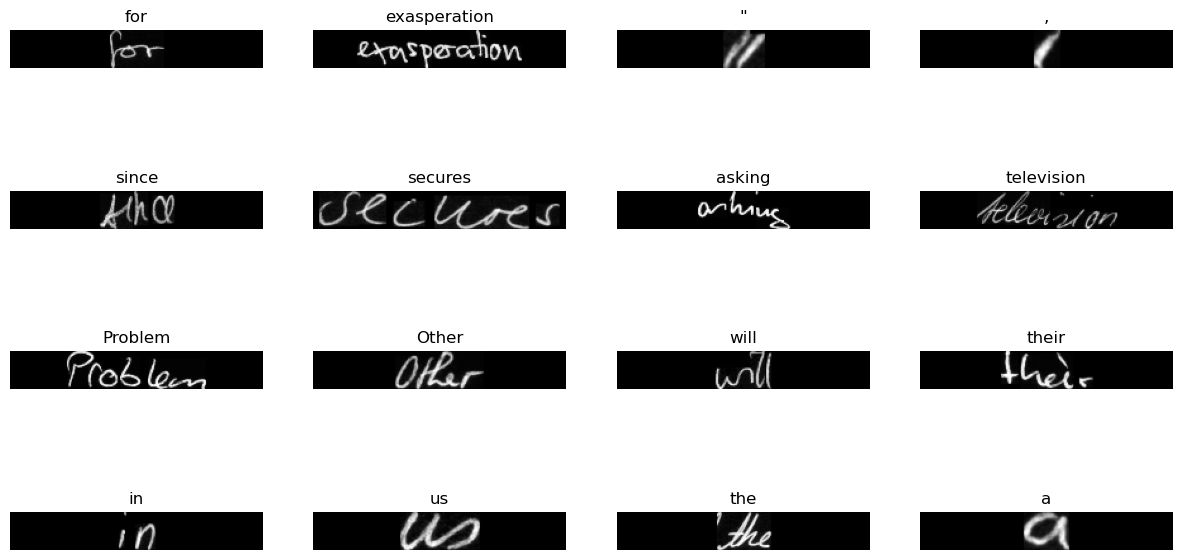

In [15]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= 99.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# New Model

This section contains a basic model using CTC loss as an endpoint layer. <br>

More about CTC loss: https://distill.pub/2017/ctc/

In [16]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img =  keras.Input(
        shape=(image_width, image_height, 1), name="image")
    labels =  keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x =  keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x =  keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x =  keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x =  keras.layers.Dropout(0.2)(x)

    # RNNs.
    x =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (the tokenizer is char-level)
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x =  keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model =  keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt, metrics=["accuracy"])
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 30, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 30, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 15, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 15, 64)          18496     ['pool1[0][0]']               
                                                                             

## Training The Model
It is recommended that we train for at lesat 50 epochs for acceptable results.<br>

However, I'll run it at 10 epochs for now due to time constraints.

In [17]:
epochs = 10

# Train the model
model = build_model()
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
)

Epoch 1/10
1357/1357 [==============================] - 516s 375ms/step - loss: 13.6962 - val_loss: 10.5920
Epoch 2/10
1357/1357 [==============================] - 445s 328ms/step - loss: 9.5348 - val_loss: 7.7758
Epoch 3/10
1357/1357 [==============================] - 447s 329ms/step - loss: 7.3349 - val_loss: 5.6619
Epoch 4/10
1357/1357 [==============================] - 465s 343ms/step - loss: 5.8269 - val_loss: 4.5249
Epoch 5/10
1357/1357 [==============================] - 470s 346ms/step - loss: 4.8833 - val_loss: 3.8453
Epoch 6/10
1357/1357 [==============================] - 460s 339ms/step - loss: 4.2428 - val_loss: 3.2958
Epoch 7/10
1357/1357 [==============================] - 462s 340ms/step - loss: 3.8159 - val_loss: 2.9949
Epoch 8/10
1357/1357 [==============================] - 467s 344ms/step - loss: 3.4923 - val_loss: 2.7756
Epoch 9/10
1357/1357 [==============================] - 472s 348ms/step - loss: 3.2475 - val_loss: 2.5863
Epoch 10/10
1357/1357 [=====================

**Note:** It is possible that some images may be corrupted. <br>

Uncomment and run the following code to detect which images have been corrupted if such an error appears during training.<br>
Re-downloaded the data to fix it.

In [18]:
# from pathlib import Path
# import imghdr

# data_dir = "data/words/"
# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

**Plot progress history**

In [67]:
def save_progress_plot(history, file_path=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
#     ax1.plot(history.history['accuracy'], label='train accuracy', color='green', marker="o")
#     ax1.plot(history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
    ax2.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
    ax2.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
    ax1.legend(loc=3)

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='g')
    ax2.set_ylabel('Loss', color='b')
    ax2.legend(loc=5)
    plt.title("Training Progress")
    plt.savefig(file_path)
    plt.close()

In [68]:
save_progress_plot(history, file_path='./models/htr_model/training_progress.png')

<img src="./models/htr_model/training_progress.png">

**Save and load the model**

In [19]:
# Save model
model.save('./models/htr_model')

INFO:tensorflow:Assets written to: ./models/htr_model\assets


INFO:tensorflow:Assets written to: ./models/htr_model\assets


In [20]:
model = keras.models.load_model('./models/htr_model')

## Evaluating the Model

In [21]:
model.evaluate(test_ds)

76/76 [==============================] - 40s 495ms/step - loss: 2.5714


2.5713629722595215

### Visualizing a test sample prediction

In [22]:
# Get the prediction model by extracting layers till the output layer.
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 30, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 30, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 15, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 15, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 7, 64)         0         
                                                                 
 reshape (Reshape)           (None, 50, 448)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            28736 

In [30]:
for batch in test_ds.take(1):
    batch_images = batch["image"][0]
    print(batch_images.shape)

(200, 30, 1)


2/2 [==============================] - 0s 72ms/step


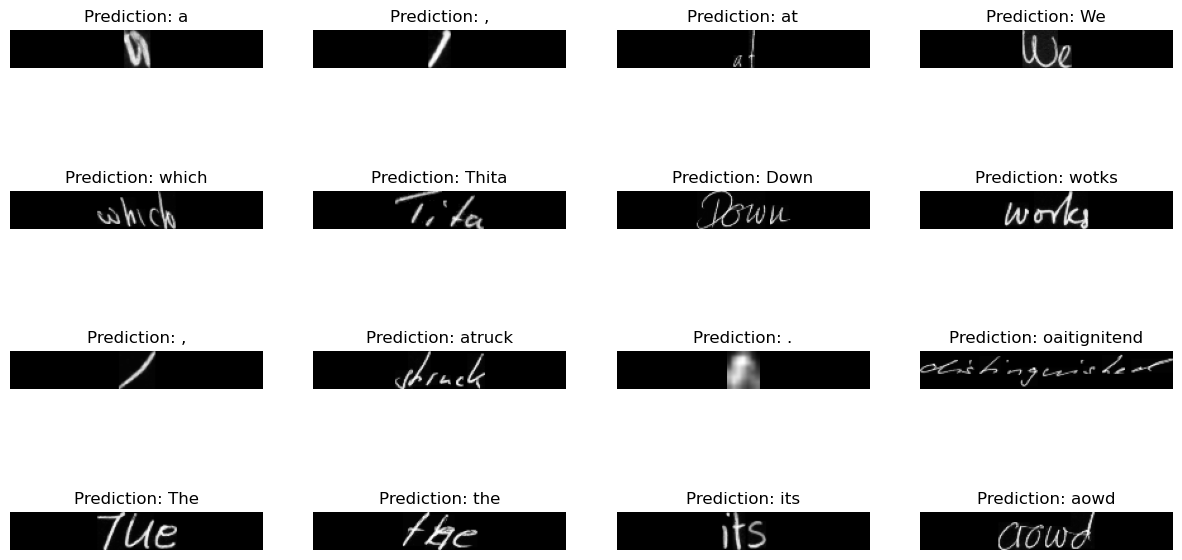

In [70]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()